<a href="https://colab.research.google.com/github/federica-dk/sentiment-classifier-project/blob/main/FinalSentimentAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Imports
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tempfile
import matplotlib as mpl

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [8]:
#Downloading th necessary data from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
#Opening the file
df = pd.read_csv('/content/Tweets.csv')

#data exploration
print('Sentiment Column Description:')
print(df['sentiment'].describe())


Sentiment Column Description:
count       27481
unique          3
top       neutral
freq        11118
Name: sentiment, dtype: object


In [10]:
print('Twitter Data Head')
df.head()

Twitter Data Head


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [11]:
#Cleaning the data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#Cleaning text function to remove any unecessary data that may cloud results
def clean_text(text):
  text = str(text).lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'#', '', text)
  text = re.sub(r'[^a-z\s]', '', text)
  #Creating the tokens of the text
  tokens = nltk.word_tokenize(text)
  #Lemmatizing the data
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
  return " ".join(tokens)

 #Calling function
df['clean_text'] = df['text'].apply(clean_text)

In [12]:
#Checking the function is working correctly
df['clean_text'].head()

,clean_text
0,id responded going
1,sooo sad miss san diego
2,bos bullying
3,interview leave alone
4,son couldnt put release already bought


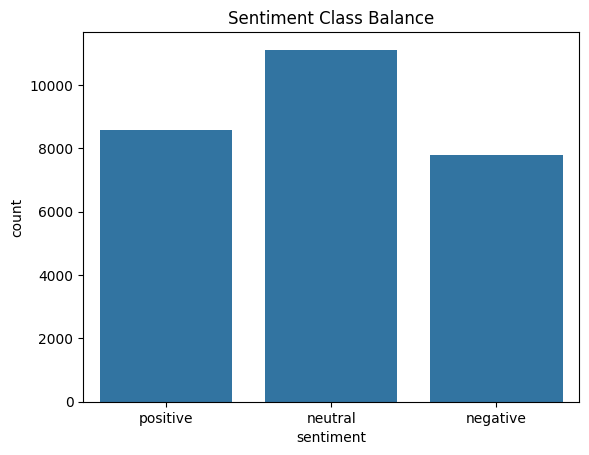

In [13]:
#Creating the Class Balance visual
sentiment_counts = df['sentiment'].value_counts()
sns.countplot(x='sentiment', data=df, order=['positive','neutral','negative'])
plt.title('Sentiment Class Balance')
plt.show()


In [14]:
#Spliting data
df['clean_text'] = df['text'].apply(clean_text)
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

Naive Bayes Accuracy: 0.625068219028561
Naive Bayes Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.41      0.54      1562
     neutral       0.54      0.82      0.65      2230
    positive       0.74      0.57      0.65      1705

    accuracy                           0.63      5497
   macro avg       0.69      0.60      0.61      5497
weighted avg       0.68      0.63      0.62      5497



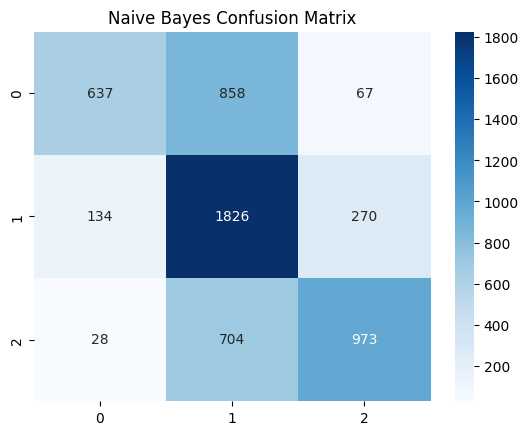

In [15]:
#Naive Bayes baseline
nb_model = MultinomialNB()
nb_model.fit(X_train_vectors, y_train)

y_pred_nb = nb_model.predict(X_test_vectors)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))

nb_cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [16]:
svm_model = SVC()
svm_model.fit(X_train_vectors, y_train)

KeyboardInterrupt: 

In [ ]:
y_pred_svm = svm_model.predict(X_test_vectors)

In [ ]:
#Accuracy Score + Classification report
print(f'SVM Accuracy: { accuracy_score(y_test, y_pred_svm)}')
print(f'Classification Report: {classification_report(y_test, y_pred_svm)}')

#Confusion Matrix
svm_cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Pinks')
plt.title('SVM Confusion Matrix')
plt.show()

In [ ]:
#ROC Curve (ROC = a visual representation of model performance across all thresholds)

#filter positive and negative for ROC
df_binary = df[df['sentiment'].isin(['positive', 'negative'])]
X_bin = df_binary['clean_text']
y_bin = df_binary['sentiment'].map({'negative':0, 'positive':1})
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42
)

X_train_vec_b = vectorizer.fit_transform(X_train_b)
X_test_vec_b = vectorizer.transform(X_test_b)

svm_bin = SVC(probability=True)
svm_bin.fit(X_train_vec_b, y_train_b)

y_scores = svm_bin.predict_proba(X_test_vec_b)[:,1]

fpr, tpr, thresholds = roc_curve(y_test_b, y_scores)
roc_auc = auc(fpr, tpr)


In [ ]:
#Output
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve (Pos vs. Neg)')
plt.legend()
plt.show()

In [ ]:
#Grid Search for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=3)
grid.fit(X_train_vectors, y_train)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)

In [ ]:
#Generating Word Clouds

# Word Cloud for Top Positive Words
if positive_text: # Only generate if there's text
    plt.figure(figsize=(12, 8))
    wordcloud_positive = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap='viridis', # A nice colormap for positive words
        min_font_size=10,
        max_words=100 # Limit to top 100 words
    ).generate(positive_text)

    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off') # Hide axes
    plt.title('Top Positive Words', fontsize=16)
    plt.show() # Display the plot
else:
    print("No positive text found for word cloud generation.")

# Word Cloud for Top Negative Words
if negative_text: # Only generate if there's text
    plt.figure(figsize=(12, 8))
    wordcloud_negative = WordCloud(
        width=1000,
        height=500,
        background_color='black', # Dark background for negative words
        colormap='inferno', # A colormap that might convey intensity
        min_font_size=10,
        max_words=100 # Limit to top 100 words
    ).generate(negative_text)

    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off') # Hide axes
    plt.title('Top Negative Words', fontsize=16, color='white') # Title color for visibility on black background
    plt.show() # Display the plot
else:
    print("No negative text found for word cloud generation.")

# Optional: Word Cloud for Top Neutral Words
if neutral_text:
    plt.figure(figsize=(12, 8))
    wordcloud_neutral = WordCloud(
        width=1000,
        height=500,
        background_color='grey', # A neutral background
        colormap='magma', # A different colormap
        min_font_size=10,
        max_words=100
    ).generate(neutral_text)

    plt.imshow(wordcloud_neutral, interpolation='bilinear')
    plt.axis('off')
    plt.title('Top Neutral Words', fontsize=16)
    plt.show() # Display the plot
else:
    print("No neutral text found for word cloud generation.")
#Create Count Plot for Sentiment Class Balance

plt.figure(figsize=(8, 6))
# Ensure 'sentiment' column exists in df
sns.countplot(x='sentiment', data=df, palette='coolwarm', order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Class Balance', fontsize=16)
plt.xlabel('Sentiment Class', fontsize=12)
plt.ylabel('Number of Entries', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
plt.show() # Display the plot